# [ATM 623: Climate Modeling](../index.ipynb)

[Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany

## Introducing the Community Earth System Model (CESM)

## Warning: content out of date and not maintained

You really should be looking at [The Climate Laboratory book](https://brian-rose.github.io/ClimateLaboratoryBook) by Brian Rose, where all the same content (and more!) is kept up to date.

***Here you are likely to find broken links and broken code.***

In [1]:
#  Ensure compatibility with Python 2 and 3
from __future__ import print_function, division

This notebook contains a tutorial on the CESM model, and how to work with `NetCDF` data in Python using the `xarray` package. There are simple homework questions throughout the tutorial. Their purpose is just to get you up to speed on working with the model input and output files.

## Your assigment

1. Read and understand the whole tutorial. 
2. Answer every (clearly marked) homework question.
3. Write up your answers (including text, code and figures) in a new IPython notebook. *Try to make sure that your notebook runs cleanly from start to finish.*
5. Save your notebook as `[your last name].ipynb`, e.g. my notebook should be called `Rose.ipynb`.  *This makes it easier for me when I collect all your answers*
4. ~~Submit your answers by email before class on **Thursday February 16**.~~

Actually I will **not** be collecting your answers. But make sure you understand what's in here, because you will need to apply these skills on the next homework.

## About the Slab Ocean Model

We are using a version of the Community Earth System Model (CESM) which is developed and maintained at the National Center for Atmospheric Research in Boulder, CO. See the CESM website here: 
<http://www2.cesm.ucar.edu>

Our experiments will use CESM in the so-called **Slab Ocean Model** mode, in which **the ocean is represented by a static layer of water with some fixed heat capacity** but no motion.

This greatly simplifies the necessary calculations, particularly the time required for the model to reach equilibrium. The net effect heat transport by ocean currents is prescribed through a so-called **q-flux**, which really just means we prescribe sources and sinks of heat at different locations. 

For (lots of) details, see <http://www2.cesm.ucar.edu/working-groups/pwg/documentation/cesm1-paleo-toolkit/ocean/som>

### Resolusion
The governing equations (fluid dynamics, radiation, etc.) are continuous in space and time.

Like every GCM, the model solves approximations to these equations that are *discretized* to a finite grid.

The spatial resolution of each component is:

- Atmosphere: 2º latitude-longitude grid in the horizontal, 26 vertical levels.
- Land: same grid as atmosphere
- Sea ice and slab ocean: about 1º horizontal 

The model runs on a local compute cluster here at UAlbany. We can simulate about 5 years per day by running the model on 32 cores. Equilibration time for the slab ocean model is roughly 20 years. Thus it takes a few days to run any particularly scenario out to equilibrium. The atmospheric GCM uses about half of the cpu time, the sea ice uses about one quarter, and the rest goes to the land model, the coupler, and various other bits and pieces.

We will begin with a **control run**, i.e. we will set up the model with (approximately) realistic conditions and run it out to equilibrium. We can then measure how well our simulated climate agrees with observations.

___________________________
## HOMEWORK QUESTION 1:
Think about which important climate processes you expect will or will not be well resolved by a model with 2º horizontal resolution.

**List at least one process that you think IS well resolved.**

**List at least one prcess that you think IS NOT well resolved.**
____________________________

## Description of input

First, let's take a look at some of the ingredients that go into the control run. **All of the necessary data will be served up by a special data server sitting in the department**, so you should be able to run this code to interact with the data on any computer that is connected to the internet.

### You need to be connected to the internet to run the code in this notebook ###

You can browse the available data through a web interface here:

<http://ramadda.atmos.albany.edu:8080/repository/entry/show/Top/Users/BrianRose/CESM_runs>

Within this folder called `CESM runs`, you will find another folder called `som_input` which contains all the input files.

The data are all stored in `NetCDF` files. Python has some nice interfaces for working with `NetCDF` data files, including accessing files remotely over the internet. To begin, we need to import the Python package `netCDF4` to read the data files.

We also set the notebook to `inline` graphics mode to display figures right here in the notebook.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

You are encouraged to experiment and tinker with all the code below.

We are going to use a package called [xarray](http://xarray.pydata.org) (abbreviated here as `xr`) to work with the datasets.

### Boundary conditions: continents and topography

Here we are going to load the input topography file and take a look at what's inside. 

We use the `Dataset` object from the `netCDF4` module as our basic container for any `netCDF` data. `Dataset()` requires at least one argument telling it what file to open. This can either be a file on your local disk or a URL.

In this case we are passing it a URL to our online dataserver. We'll put the URL in a string variable called `datapath` to simplify things later on.

In [3]:
datapath = "http://ramadda.atmos.albany.edu:8080/repository/opendap/latest/Top/Users/BrianRose/CESM_runs/"
endstr = "/entry.das"

#  Notice that in Python we can easily concatenate strings together just by `adding` them
fullURL = datapath + 'som_input/USGS-gtopo30_1.9x2.5_remap_c050602.nc' + endstr
print( fullURL)

http://ramadda.atmos.albany.edu:8080/repository/opendap/latest/Top/Users/BrianRose/CESM_runs/som_input/USGS-gtopo30_1.9x2.5_remap_c050602.nc/entry.das


In [4]:
#  Now we actually open the dataset
topo = xr.open_dataset( fullURL )
print( topo)

<xarray.Dataset>
Dimensions:       (lat: 96, lon: 144)
Coordinates:
  * lat           (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon           (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    PHIS          (lat, lon) float64 ...
    SGH           (lat, lon) float64 ...
    SGH30         (lat, lon) float64 ...
    LANDFRAC      (lat, lon) float64 ...
    LANDM_COSLAT  (lat, lon) float64 ...
Attributes:
    history:    Written on date: 20050602\ndefinesurf -remap -t /fs/cgd/csm/i...
    make_ross:  true
    topofile:   /fs/cgd/csm/inputdata/atm/cam/topo/USGS-gtopo30_10min_c050419.nc
    gridfile:   /fs/cgd/csm/inputdata/atm/cam/coords/fv_1.9x2.5.nc
    landmask:   /fs/cgd/csm/inputdata/atm/cam2/hrtopo/landm_coslat.nc


The `Dataset` object has several important attributes. Much of this should look familiar if you have worked with `netCDF` data before. The `xarray` package gives a very powerful and easy to use interface to the data.

We can access individual variables within the `xarray.Dataset` object as follows:

In [5]:
topo.PHIS

<xarray.DataArray 'PHIS' (lat: 96, lon: 144)>
array([[2.796465e+04, 2.796465e+04, 2.796465e+04, ..., 2.796465e+04,
        2.796465e+04, 2.796465e+04],
       [2.718626e+04, 2.724515e+04, 2.730367e+04, ..., 2.699761e+04,
        2.706319e+04, 2.712589e+04],
       [2.562017e+04, 2.579349e+04, 2.595301e+04, ..., 2.497548e+04,
        2.521368e+04, 2.542803e+04],
       ...,
       [1.720216e-02, 7.134989e-03, 2.748055e-03, ..., 1.569097e-01,
        8.055879e-02, 3.857289e-02],
       [5.444020e-02, 3.951677e-02, 2.799566e-02, ..., 1.231596e-01,
        9.609957e-02, 7.320690e-02],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]])
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    long_name:   surface geopotential
    units:       m2/s2
    from_hires:  true
    filter:      remap

### Plotting the topography

We will now read the geopotential and make a plot of the topography of the Earth's surface as represented on the 2º grid. The code below makes a colorful plot of the topography. We also use the land-sea mask in order to plot nothing at grid points that are entirely ocean-covered. 

Execute this code exactly as written first, and then play around with it to see how you might customize the graph. 

Note that the function `pcolormesh` does most of the work here. It's a function that makes color 2D plots of an array.

In [6]:
g = 9.8  # gravity in m/s2
meters_per_kilometer = 1E3 
height = topo.PHIS / g / meters_per_kilometer  # in kilometers
#  Note that we have just created a new xarray.DataArray object that preserves the axis labels
#  Let's go ahead and give it some useful metadata:
height.attrs['units'] = 'km'
height.name = 'height'
height

<xarray.DataArray 'height' (lat: 96, lon: 144)>
array([[2.853536e+00, 2.853536e+00, 2.853536e+00, ..., 2.853536e+00,
        2.853536e+00, 2.853536e+00],
       [2.774108e+00, 2.780118e+00, 2.786089e+00, ..., 2.754858e+00,
        2.761550e+00, 2.767948e+00],
       [2.614303e+00, 2.631989e+00, 2.648266e+00, ..., 2.548518e+00,
        2.572824e+00, 2.594697e+00],
       ...,
       [1.755323e-06, 7.280601e-07, 2.804138e-07, ..., 1.601120e-05,
        8.220284e-06, 3.936009e-06],
       [5.555123e-06, 4.032323e-06, 2.856700e-06, ..., 1.256730e-05,
        9.806078e-06, 7.470092e-06],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]])
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    units:    km

In [7]:
height.name

'height'

Let's make a plot! `xarray` is able to automatically generate labeled plots. This is very handy for "quick and dirty" investigation of the data:

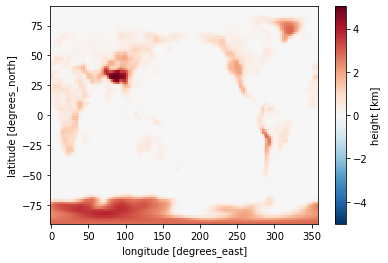

In [8]:
height.plot()

If we want more control over the appearance of the plot, we can use features of `matplotlib`

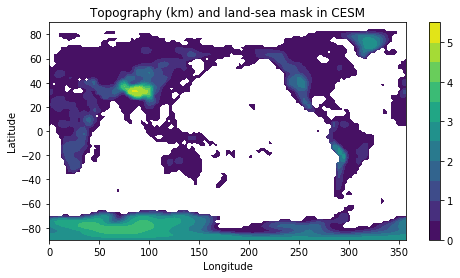

In [9]:
#  A filled contour plot of topography with contours every 500 m
lev = np.arange(0., 6., 0.5)
fig1, ax1 = plt.subplots(figsize=(8,4))
# Here we are masking the data to exclude points where the land fraction is zero (water only)
cax1 = ax1.contourf( height.lon, height.lat, 
                    height.where(topo.LANDFRAC>0), levels=lev)
ax1.set_title('Topography (km) and land-sea mask in CESM')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
cbar1 = fig1.colorbar(cax1)

Note that at 2º resolution we can see many smaller features (e.g. Pacific islands). The model is given a fractional land cover for each grid point. 

Here let's plot the land-sea mask itself so we can see where there is at least "some" water:

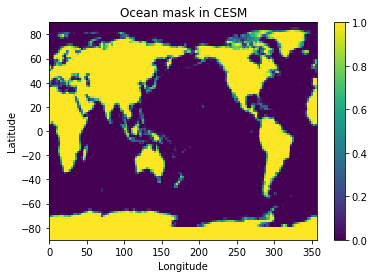

In [10]:
fig2, ax2 = plt.subplots()
cax2 = ax2.pcolormesh( topo.lon, topo.lat, topo.LANDFRAC )
ax2.set_title('Ocean mask in CESM')
ax2.set_xlabel('Longitude'); ax2.set_ylabel('Latitude')
cbar2 = fig2.colorbar(cax2);

### Making nicer maps

Notice that to make these plots we've just plotted the lat-lon array without using any map projection.

There are nice tools available to make better maps. We'll leave that as a topic for another day. But if you're keen to read ahead, check out:

<http://matplotlib.org/basemap/>

and

<http://scitools.org.uk/cartopy/>

(We will probably be using `cartopy` later in this course because it is 

## Ocean boundary conditions

Another important input file contains information about the slab ocean. You can see this file in the data catalog here:

<http://ramadda.atmos.albany.edu:8080/repository/entry/show/Top/Users/BrianRose/CESM_runs/som_input/pop_frc.1x1d.090130.nc>

Let's load it and take a look.

In [11]:
som_input = xr.open_dataset( datapath + 'som_input/pop_frc.1x1d.090130.nc' + endstr, decode_times=False )
print( som_input)

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 12)
Coordinates:
  * time     (time) float32 14.0 46.0 74.0 105.0 ... 258.0 288.0 319.0 349.0
Dimensions without coordinates: lat, lon
Data variables:
    area     (lat, lon) float64 ...
    mask     (lat, lon) int32 ...
    yc       (lat) float32 ...
    xc       (lon) float32 ...
    S        (time, lat, lon) float32 ...
    T        (time, lat, lon) float32 ...
    U        (time, lat, lon) float32 ...
    V        (time, lat, lon) float32 ...
    dhdx     (time, lat, lon) float32 ...
    dhdy     (time, lat, lon) float32 ...
    hblt     (time, lat, lon) float32 ...
    qdp      (time, lat, lon) float32 ...
Attributes:
    creation_date:  Fri Jan 30 10:22:53 MST 2009
    comment:        This data is on a standard 1x1d grid.
    calendar:       standard
    author:         D. Bailey
    note3:          qdp is computed from depth summed ocean column
    note2:          all fields interpolated to T-grid
    note1:          field

The ocean / sea ice models exist on different grids than the atmosphere (1º instead of 2º resolution).

Now we are going to look at the **annual mean heat flux out of the ocean**, which is the prescribed 'q-flux' that we give to the slab ocean model.

It is stored in the field `qdp` in the input file. 

The sign convention in CESM is that `qdp > 0` where **heat is going IN to the ocean**. We will change the sign to plot heat going OUT of the ocean INTO the atmosphere (a more atmosphere-centric viewpoint). 

In [12]:
som_input.qdp

<xarray.DataArray 'qdp' (time: 12, lat: 180, lon: 360)>
[777600 values with dtype=float32]
Coordinates:
  * time     (time) float32 14.0 46.0 74.0 105.0 ... 258.0 288.0 319.0 349.0
Dimensions without coordinates: lat, lon
Attributes:
    spatial_op:  Bilinear remapping: 1st order: destarea: NCL: ./map_gx1v5_to...

Unfortunately, here is a case in which the metadata are not very useful. There is no text description of what variable `qdp` actually is, or what its units are.  (It is actually in units of W/m2)

We can see that there are 12 x 180 x 360 data points. One 180 x 360 grid for each calendar month!

Now we are going to take the average over the year at each point. We will use a very convenient `numpy` array function `np.mean()`, which just computes the point-by-point average. This leaves us with a single grid on 180 latitude points by 360 longitude points:

/Users/br546577/anaconda3/envs/climlab-courseware/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


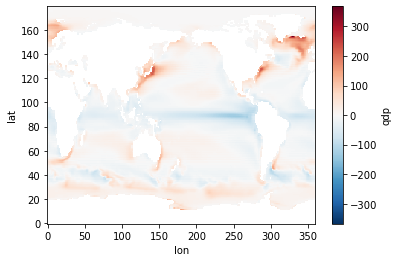

In [13]:
(-som_input.qdp.mean(dim='time')).plot()

Now make a nice plot of the annual mean q-flux. 

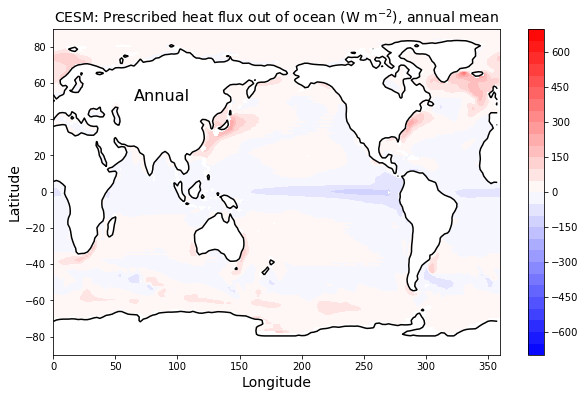

In [14]:
#  We can always set a non-standard size for our figure window
fig3, ax3 = plt.subplots(figsize=(10, 6))
lev = np.arange(-700., 750., 50.)
cax3 = ax3.contourf(som_input.xc, som_input.yc, 
                    -som_input.qdp.mean(dim='time'), 
                    levels=lev, cmap=plt.cm.bwr)
cbar3 = fig3.colorbar(cax3)
ax3.set_title( 'CESM: Prescribed heat flux out of ocean (W m$^{-2}$), annual mean', 
              fontsize=14 )
ax3.set_xlabel('Longitude', fontsize=14)
ax3.set_ylabel('Latitude', fontsize=14)
ax3.text(65, 50, 'Annual', fontsize=16 )
ax3.contour(topo.lon, topo.lat, topo.LANDFRAC, levels=[0.5], colors='k');

Notice all the spatial structure here: 

- Lots of heat is going in to the oceans at the equator, particularly in the eastern Pacific Ocean.
- The red hot spots show where lots of heat is coming out of the ocean.
- Hot spots include the mid-latitudes off the eastern coasts of Asia and North America
- And also the northern North Atlantic. 

**All this structure is determined by ocean circulation, which we are not modeling here.** Instead, we are prescribing these heat flux patterns as an input to the atmosphere.

This pattern changes throughout the year. Recall that we just averaged over all months to make this plot. We might want to look at just one month:

In [15]:
# select by month index (0 through 11)
som_input.qdp.isel(time=0)

<xarray.DataArray 'qdp' (lat: 180, lon: 360)>
array([[      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       ...,
       [-5.75126 , -5.742314, -5.734764, ..., -5.792866, -5.774798, -5.761612],
       [-5.533446, -5.537023, -5.540624, ..., -5.522859, -5.526363, -5.529893],
       [-5.31631 , -5.314115, -5.311888, ..., -5.322703, -5.320605, -5.318473]],
      dtype=float32)
Coordinates:
    time     float32 14.0
Dimensions without coordinates: lat, lon
Attributes:
    spatial_op:  Bilinear remapping: 1st order: destarea: NCL: ./map_gx1v5_to...

In [16]:
#  select by array slicing (but for this you have to know the axis order!)
som_input.qdp[0,:,:]

<xarray.DataArray 'qdp' (lat: 180, lon: 360)>
array([[      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       ...,
       [-5.75126 , -5.742314, -5.734764, ..., -5.792866, -5.774798, -5.761612],
       [-5.533446, -5.537023, -5.540624, ..., -5.522859, -5.526363, -5.529893],
       [-5.31631 , -5.314115, -5.311888, ..., -5.322703, -5.320605, -5.318473]],
      dtype=float32)
Coordinates:
    time     float32 14.0
Dimensions without coordinates: lat, lon
Attributes:
    spatial_op:  Bilinear remapping: 1st order: destarea: NCL: ./map_gx1v5_to...

Here we got just the first month (January) by specifying `[0,:,:]` after the variable name. This is called *slicing* or *indexing* an array. We are saying "give me everything for month number 0". Now make the plot:

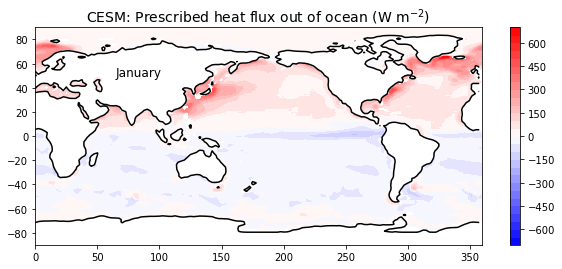

In [17]:
fig4, ax4 = plt.subplots(figsize=(10,4)) 
cax4 = ax4.contourf( som_input.xc, som_input.yc, 
                    -som_input.qdp.isel(time=0), 
                      levels=lev, cmap=plt.cm.bwr)
cbar4 = plt.colorbar(cax4)
ax4.set_title( 'CESM: Prescribed heat flux out of ocean (W m$^{-2}$)', 
              fontsize=14 )
ax3.set_xlabel('Longitude', fontsize=14)
ax3.set_ylabel('Latitude', fontsize=14)
ax4.text(65, 50, 'January', fontsize=12 );
ax4.contour(topo.lon, topo.lat, topo.LANDFRAC, levels=[0.5], colors='k');

Now try to plot a different month by indexing the array differently. 

___________________________
## HOMEWORK QUESTION 2:
**Describe in a few sentences how the pattern of heat flux in and out of the oceans changes throughout the year.**
____________________________

### Just for fun: some interactive plotting

`IPython` provides some really neat and easy-to-use tools to set up interactive graphics in your notebook.

Here we're going to create a figure with a slider that lets of step through each month of the q-flux data.

In [18]:
# A list of text labels for each month
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 
         'Sep', 'Oct', 'Nov', 'Dec']

In [19]:
# an example of slicing this list:
months[-2:]

['Nov', 'Dec']

In [20]:
#  A function that takes a month index (0 - 11) and creates a plot just like above
def sh(month):
    fig, ax = plt.subplots(figsize=(10,4)) 
    cax = ax.contourf( som_input.xc, som_input.yc, 
                      -som_input.qdp.isel(time=month), 
                      levels=lev, cmap=plt.cm.bwr)
    cbar = plt.colorbar(cax)
    ax.set_title( 'CESM: Prescribed heat flux out of ocean (W m$^{-2}$)', 
              fontsize=14 )
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    ax.text(65, 50, months[month], fontsize=12 );
    ax.contour(topo.lon, topo.lat, topo.LANDFRAC, levels=[0.5], colors='k');

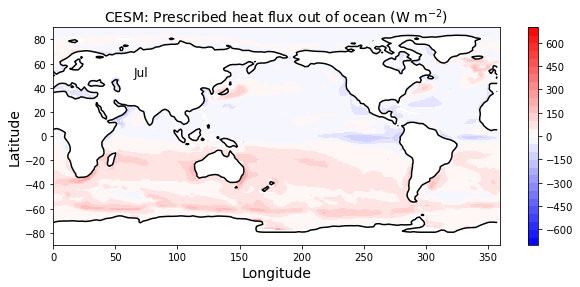

In [21]:
# Calling this function with a single month index gives us a single plot:
sh(6)

When you execute the next cell, you should get a figure with a slider above it. Go ahead and play with it.

In [22]:
#  This requires IPython 4 and above
from ipywidgets import interact
interact(sh, month=(0,11,1));

interactive(children=(IntSlider(value=5, description='month', max=11), Output()), _dom_classes=('widget-intera…

## The "pre-industrial" control run

Our control run is set up to simulate the climate of the "pre-industrial era", meaning before significant human-induced changes to the composition of the atmosphere, nominally the year 1850.

Output from the control run is available on the same data server as above. Look in the folder called `som_1850_f19` (Here `som` stands for "slab ocean model", 1850 indicated pre-industrial conditions, and `f19` is a code for the horizontal grid resolution).

There are climatology files for each active model component:

- atmosphere, 
- sea ice
- land surface 

I created these files by **averaging over the last 10 years of the simulation**. Let's take a look at the atmosphere file. The file is called

`som_1850_f19.cam.h0.clim.nc`

(the file extension `.nc` is used to indicate NetCDF format).

In [23]:
atm_control = xr.open_dataset( datapath + 'som_1850_f19/som_1850_f19.cam.h0.clim.nc' + endstr )

print( atm_control)

<xarray.Dataset>
Dimensions:       (ilev: 27, lat: 96, lev: 26, lon: 144, nbnd: 2, slat: 95, slon: 144, time: 12)
Coordinates:
  * lev           (lev) float64 3.545 7.389 13.97 23.94 ... 929.6 970.6 992.6
  * ilev          (ilev) float64 2.194 4.895 9.882 18.05 ... 956.0 985.1 1e+03
  * time          (time) object 0001-01-15 00:00:00 ... 0001-12-15 00:00:00
  * lat           (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon           (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * slat          (slat) float64 -89.05 -87.16 -85.26 ... 85.26 87.16 89.05
  * slon          (slon) float64 -1.25 1.25 3.75 6.25 ... 351.2 353.8 356.2
Dimensions without coordinates: nbnd
Data variables:
    hyam          (lev) float64 ...
    hybm          (lev) float64 ...
    hyai          (ilev) float64 ...
    hybi          (ilev) float64 ...
    P0            float64 ...
    date          (time) int32 ...
    datesec       (time) int32 ...
    w_stag        (slat) flo

Lots of different stuff! These are all the different quantities that are calculated as part of the model simulation. **Every quantity represents a long-term average for a particular month**. 

Want to get more information about a particular variable?

In [24]:
atm_control.co2vmr

<xarray.DataArray 'co2vmr' (time: 12)>
array([0.000285, 0.000285, 0.000285, 0.000285, 0.000285, 0.000285, 0.000285,
       0.000285, 0.000285, 0.000285, 0.000285, 0.000285])
Coordinates:
  * time     (time) object 0001-01-15 00:00:00 ... 0001-12-15 00:00:00
Attributes:
    long_name:     co2 volume mixing ratio
    cell_methods:  time: mean

This is the (prescribed) amount of CO2 in the atmosphere (about 285 parts per million by volume).

One nice thing about `xarray.DataArray` objects is that we can do simple arithmetic with them (already seen several examples of this in the notes above). For example, change the units of CO2 amount to ppm:

In [25]:
atm_control.co2vmr * 1E6

<xarray.DataArray 'co2vmr' (time: 12)>
array([284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7, 284.7,
       284.7, 284.7])
Coordinates:
  * time     (time) object 0001-01-15 00:00:00 ... 0001-12-15 00:00:00

Here's another variable:

In [26]:
print( atm_control.SOLIN)

<xarray.DataArray 'SOLIN' (time: 12, lat: 96, lon: 144)>
[165888 values with dtype=float32]
Coordinates:
  * time     (time) object 0001-01-15 00:00:00 ... 0001-12-15 00:00:00
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    Sampling_Sequence:  rad_lwsw
    units:              W/m2
    long_name:          Solar insolation
    cell_methods:       time: mean time: mean


Apparently this is the incoming solar radiation or **insolation**, with shape (12,96,144) meaning it's got 12 months, 96 latitude points and 144 longitude points. 

___________________________
## HOMEWORK QUESTION 3:

**Make two well-labeled plots of the insolation:** 
1. The annual mean
2. The (June - December) difference
____________________________

## Comparing the control run with the observed energy budget

Recall that our investigations so far have been guided by this figure of the observed **annual, global mean energy budget**:

<img src='../images/GlobalEnergyBudget.png' width=800>

### The global average

In order to compare these numbers with the control run, **we need to take global averages** of the data.

A global average **must be weighted by the area of each grid cell**. We cannot simply average over each data point on a latitude-longitude grid.

___________________________
## HOMEWORK QUESTION 4:

Explain in words (no more than a few sentences) why taking the simple average of every grid point on a regular latitude-longitude grid is NOT equivalent to a global average.
____________________________

## Weighting for global average

The global average needs to weighted by the **cosine of latitude** (do you understand why?)

We can implement this in `xarray` as follows:

In [27]:
#  functions available in xarray for standard mathematical operations
#  (but still preserving DataArray attributes and axes)
from xarray.ufuncs import cos, deg2rad

In [28]:
#  Take the cosine of latitude (first converting to radians)
coslat = cos(deg2rad(atm_control.lat))
#  And divide by its mean value
weight_factor = coslat / coslat.mean(dim='lat') 

In [29]:
#  Want to see what we just created?
print( weight_factor)

<xarray.DataArray 'lat' (lat: 96)>
array([9.720485e-17, 5.248730e-02, 1.049172e-01, 1.572324e-01, 2.093756e-01,
       2.612899e-01, 3.129185e-01, 3.642049e-01, 4.150931e-01, 4.655273e-01,
       5.154525e-01, 5.648141e-01, 6.135580e-01, 6.616311e-01, 7.089806e-01,
       7.555549e-01, 8.013030e-01, 8.461749e-01, 8.901215e-01, 9.330948e-01,
       9.750478e-01, 1.015935e+00, 1.055710e+00, 1.094332e+00, 1.131757e+00,
       1.167944e+00, 1.202854e+00, 1.236449e+00, 1.268692e+00, 1.299547e+00,
       1.328981e+00, 1.356963e+00, 1.383460e+00, 1.408445e+00, 1.431889e+00,
       1.453768e+00, 1.474057e+00, 1.492734e+00, 1.509779e+00, 1.525173e+00,
       1.538899e+00, 1.550943e+00, 1.561290e+00, 1.569931e+00, 1.576854e+00,
       1.582054e+00, 1.585523e+00, 1.587259e+00, 1.587259e+00, 1.585523e+00,
       1.582054e+00, 1.576854e+00, 1.569931e+00, 1.561290e+00, 1.550943e+00,
       1.538899e+00, 1.525173e+00, 1.509779e+00, 1.492734e+00, 1.474057e+00,
       1.453768e+00, 1.431889e+00, 1.4084

### An alternative: use weights already provided in the dataset

You will find that many gridded datasets already provide a field that gives accurate area weighting.

In the case of the CESM output, the field is called `gw`

In [30]:
weight_factor2 = atm_control.gw / atm_control.gw.mean(dim='lat')

In [31]:
#  Compare our two weights
print( (atm_control.FLNT * weight_factor).mean(dim=('time', 'lon', 'lat')))
print( (atm_control.FLNT * weight_factor2).mean(dim=('time', 'lon', 'lat')))

<xarray.DataArray ()>
array(234.145726)
<xarray.DataArray ()>
array(234.135526)


Very close, the difference is insignificant.

___________________________
## HOMEWORK QUESTION 5:

Make sure you can take a global average, testing on **surface temperature** in the control run.

Surface temperature is called `'TS'` in the control run data file.

**Calculate annual, global average `'TS'`**

**Verify that you get something close to `289.57`**

If it doesn't, try to find and fix the errors.
____________________________

### Finding the radiative fluxes in the model output

Now that you have a working function to take global averages, we can compare some energy budget values against observations.

The model output contains lots of diagnostics about the radiative fluxes. Here some CESM naming conventions to help you find the appropriate output fields:

- All variables whose names being with `'F'` are an **energy flux** of some kind. 
- Most have a four-letter code, e.g. `'FLNT'`
- `'FL'` means **longwave flux** (i.e. terrestrial)
- `'FS'` means **shortwave flux** (i.e. solar)
- The third letter indicates **direction** of the flux:
    - `'U'` = up
    - `'D'` = down
    - `'N'` = net
- The fourth letter indicates the **location** of the flux:
    - `'T'` = top of atmosphere
    - `'S'` = surface
- So `'FLNT'` means 'net longwave flux at the top of atmosphere', i.e. the outgoing longwave radiation.

You wil see that these are all 12 x 96 x 144 -- i.e. a two-dimensional grid for every calendar month.

In [32]:
atm_control.FLNT

<xarray.DataArray 'FLNT' (time: 12, lat: 96, lon: 144)>
[165888 values with dtype=float32]
Coordinates:
  * time     (time) object 0001-01-15 00:00:00 ... 0001-12-15 00:00:00
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    Sampling_Sequence:  rad_lwsw
    units:              W/m2
    long_name:          Net longwave flux at top of model
    cell_methods:       time: mean time: mean

__________________________
## HOMEWORK QUESTION 6:

Compute annual, global averages of the following four quantities. 

1. Incoming solar radiation (or insolation)
2. Absorbed solar radiation
3. Planetary albedo
4. Outgoing longwave radiation

Compare your results briefly to the observations.
____________________________

## About all-sky versus clear-sky radiative fluxes

The GCM computes cloud cover prognostically as part of its simulation of current weather conditions. These clouds affect both longwave and shortwave radiative fluxes in important ways (as we will study later).

At each timestep, the CESM (like just about every other GCM) actually computes two kinds of radiative fluxes:

- the actual flux, including the effects of current cloud cover
- a **clear-sky** flux -- the flux that would occur if there were no clouds (or the flux that you would measure if you looked only at the clear-sky parts of the scene)

For example, there are two *outgoing longwave radiation* fields:

In [33]:
for var in ['FLNT', 'FLNTC']:
    print( var)
    print( atm_control[var].long_name)
    print( atm_control[var].units)
    print( '')

FLNT
Net longwave flux at top of model
W/m2

FLNTC
Clearsky net longwave flux at top of model
W/m2



We can compute what is called the **Cloud Radiative Effect** or CRE by taking the difference (all-sky minus clear-sky)

In [34]:
CRE_LW = atm_control.FLNT - atm_control.FLNTC

This field then represents the effects of clouds on the OLR.

We can of course do the same thing with the shortwave fluxes.

## A few more tidbits

That's it for homework questions. But feel free to keep exploring the data.

Many other fields are four-dimensional (time, level, latitude, longitude). 

For example, here is the shape of the array that hold the **air temperature** at every point and every month:

In [35]:
atm_control['T'].shape

(12, 26, 96, 144)

### An important *gotcha* with `xarray`

Normally we can access a variable with the notation `Dataset.variable_name`

But in `xarray` (and also in `numpy` and other packages), the notation `object.T` actually represents the **transpose** operator:

In [36]:
print( atm_control.FLNT.shape)
print( atm_control.FLNT.T.shape)

(12, 96, 144)
(144, 96, 12)


Here there is a name conflict because the air temperature variable is called `T`. One solution is to access it through the dictionary method, as I did above:

In [37]:
atm_control['T']

<xarray.DataArray 'T' (time: 12, lev: 26, lat: 96, lon: 144)>
[4313088 values with dtype=float32]
Coordinates:
  * lev      (lev) float64 3.545 7.389 13.97 23.94 ... 867.2 929.6 970.6 992.6
  * time     (time) object 0001-01-15 00:00:00 ... 0001-12-15 00:00:00
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    mdims:         1
    units:         K
    long_name:     Temperature
    cell_methods:  time: mean time: mean

Another solution is just to rename the variable (here going from `T` to `Ta`):

In [38]:
atm_control = atm_control.rename({'T': 'Ta'})
atm_control.Ta

<xarray.DataArray 'Ta' (time: 12, lev: 26, lat: 96, lon: 144)>
[4313088 values with dtype=float32]
Coordinates:
  * lev      (lev) float64 3.545 7.389 13.97 23.94 ... 867.2 929.6 970.6 992.6
  * time     (time) object 0001-01-15 00:00:00 ... 0001-12-15 00:00:00
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    mdims:         1
    units:         K
    long_name:     Temperature
    cell_methods:  time: mean time: mean

And here is some code to plot the average sounding (temperature as function of pressure) at a particular point in the month of January.

Text(0.5, 0, 'Temperature (K)')

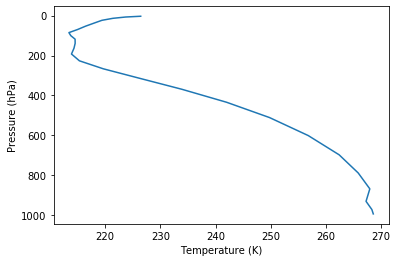

In [39]:
plt.plot( atm_control.Ta[0,:,70,115], atm_control.lev )
plt.gca().invert_yaxis()
plt.ylabel('Pressure (hPa)')
plt.xlabel('Temperature (K)')

What was the location we just used for that plot? Let's check by indexing the latitude and longitude arrays we previously stored:

In [40]:
print( atm_control.lat[70].values)
print( atm_control.lon[115].values)

42.63157894736841
287.5


These are actually the coordinates of the Albany area (read longitude in degrees east).

### So go ahead and mess around with the model output and see what you can do with it. And have fun.

Thanks for playing!

<div class="alert alert-success">
[Back to ATM 623 notebook home](../index.ipynb)
</div>

____________
## Version information
____________

In [41]:
%load_ext version_information
%version_information numpy, matplotlib, xarray

Loading extensions from ~/.ipython/extensions is deprecated. We recommend managing extensions like any other Python packages, in site-packages.


Software versions
Python 3.7.3 64bit [Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 7.6.0
OS Darwin 17.7.0 x86_64 i386 64bit
numpy 1.16.4
matplotlib 3.1.1
xarray 0.12.1
Wed Jul 03 15:08:12 2019 EDT

____________

## Credits

The author of this notebook is [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

It was developed in support of [ATM 623: Climate Modeling](http://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2015/), a graduate-level course in the [Department of Atmospheric and Envionmental Sciences](http://www.albany.edu/atmos/index.php)

Development of these notes and the [climlab software](https://github.com/brian-rose/climlab) is partially supported by the National Science Foundation under award AGS-1455071 to Brian Rose. Any opinions, findings, conclusions or recommendations expressed here are mine and do not necessarily reflect the views of the National Science Foundation.
____________